### Installation

This cell installs the necessary libraries from the `requirements.txt` file. This ensures that all dependencies required for the notebook to run correctly are installed in the Colab environment.

In [ ]:
!pip install -r requirements.txt

### API Key and URL Setup

This cell imports the `litellm` and `openai` libraries, as well as `userdata` from `google.colab` to securely access secrets stored in the Colab environment. It then retrieves the `LITELLM_API_KEY`, `LITELLM_URL`, and `MODEL` from Colab's user data secrets, assigning them to variables for later use.

In [58]:
import litellm
from openai import OpenAI
from google.colab import userdata

LITELLM_API_KEY = userdata.get('LITELLM_API_KEY')
LITELLM_URL = userdata.get('LITELLM_URL')
MODEL = userdata.get('LITELLM_MODEL')

### Initialize OpenAI Client

This cell initializes an `OpenAI` client instance. It uses the `LITELLM_URL` as the `base_url` to point to the LiteLLM proxy and the `LITELLM_API_KEY` for authentication. This client will be used to interact with the language model through the LiteLLM proxy.

In [ ]:
# Initialize client with your proxy URL
client = OpenAI(
    base_url=LITELLM_URL,  # Your proxy URL
    api_key=LITELLM_API_KEY             # Your proxy API key
)

### Generate Non-Streaming Response

This cell demonstrates how to generate a non-streaming response from the language model using the initialized `client`. It sends a prompt asking for a two-sentence bedtime story about a unicorn and stores the entire response in the `response` variable.

In [ ]:
# non streaming response
response = client.responses.create(
    model=MODEL,
    input="Tell me a two sentence bedtime story about a unicorn.",
)

### Display Non-Streaming Response

This cell displays the complete `response` object obtained from the previous non-streaming call. This allows you to see the full structure of the response, including metadata, usage information, and the generated content.

In [ ]:
response

### Generate Streaming Response

This cell is similar to the non-streaming example but configures the client for streaming responses. It sends the same prompt and prints the response as it is generated, which can be useful for larger outputs or interactive applications.

In [ ]:
# Streaming response
response = client.responses.create(
    model=MODEL,
    input="Tell me a four sentence bedtime poem about a unicorn from klang valley.",
    stream=True,
)

full_text = []

for event in response:
    # Check if the event is a text delta
    if event.type == "response.output_text.delta":
        chunk = event.delta
        print(chunk, end="", flush=True)   # stream piece by piece
        full_text.append(chunk)
    elif event.type == "response.completed":
        print("\n\n[sstreameeerrrrred successfully!!!]")
    elif event.type == "response.error":
        print(f"\n[error] {event.error}")

final_text = "".join(full_text)
print("\nFinal text:", final_text)


Here's a gentle bedtime poem about a unicorn from Klang Valley:

In Klang Valley where the city lights gleam bright,
A magical unicorn appears each starry night.
With silver horn and mane of flowing white,
She sprinkles dreams until the morning light.

[sstreameeerrrrred successfully!!!]

Final text: Here's a gentle bedtime poem about a unicorn from Klang Valley:

In Klang Valley where the city lights gleam bright,
A magical unicorn appears each starry night.
With silver horn and mane of flowing white,
She sprinkles dreams until the morning light.


### Import Langgraph Components

This cell imports necessary components from the `langgraph` library, specifically `create_react_agent` for building reactive agents. It also imports `OpenAI` and `load_dotenv` (although `load_dotenv` is not strictly necessary when using Colab secrets) and `ChatLiteLLM` from `langchain_litellm` for integrating LiteLLM with Langchain, and `InMemorySaver` for managing conversation history.

In [ ]:
from langgraph.prebuilt import create_react_agent
import os
from openai import OpenAI
from dotenv import load_dotenv
from langchain_litellm import ChatLiteLLM
from langgraph.checkpoint.memory import InMemorySaver

### Define Langchain Model with LiteLLM

This cell defines the language model to be used within the Langchain framework, leveraging the LiteLLM integration. It initializes `ChatLiteLLM` with the previously retrieved `MODEL`, `LITELLM_URL`, and `LITELLM_API_KEY`. It also sets `custom_llm_provider` to "openai" to ensure compatibility with Langchain's OpenAI integration, enables streaming, and sets the temperature to 0 for deterministic output.

In [ ]:
# 1. Define the model
model = ChatLiteLLM(
    model=MODEL, # configured in LiteLLM
    api_base=LITELLM_URL, # URL to the LiteLLM server
    api_key=LITELLM_API_KEY, # API key for LiteLLM
    # organization=os.getenv("ORG"), # organization configured in LiteLLM
    custom_llm_provider="openai", # mimic OpenAI API
    temperature=0.0, # temperature for the model
    streaming=True, # enable streaming
    verbose=True, # enable verbose logging
)

### Define Checkpointer and Tool

This cell sets up an `InMemorySaver` as a checkpointer to store the conversation history in memory. It also defines a simple Python function `get_weather` that acts as a tool for the agent. This tool takes a city name as input and returns a hardcoded string indicating sunny weather. In a real application, this would typically involve calling an external weather API.

In [ ]:
checkpointer = InMemorySaver()

def get_weather(city: str) -> str:
    """Get weather for a given city."""
    print(f"Getting weather for city: {city}")
    return f"It's always sunny in {city}!"

### Create React Agent

This cell creates a "React" agent using `create_react_agent`. This agent is designed to react to user input and decide whether to use an available tool (like the `get_weather` function) or directly respond. It's initialized with the `model`, the list of available `tools`, a system `prompt`, and the `checkpointer` for managing conversation state.

In [ ]:
agent = create_react_agent(
    model=model,
    tools=[get_weather],
    prompt="You are a helpful assistant",
    checkpointer=checkpointer
)

### Define Thread ID

This cell defines a dictionary `thread_id` that will be used to identify a specific conversation thread. This is important for the checkpointer to store and retrieve the correct conversation history.

In [ ]:
thread_id = {"configurable": {"thread_id": "thread-1"}}

### Invoke Agent with Initial Message

This cell invokes the `agent` with an initial message from the user ("hi! i am from kuala lumpur"). The `thread_id` is passed in the configuration to associate this message with the defined thread. The agent processes this message and generates a response.

In [ ]:
agent.invoke(
    {"messages": [{"role": "user", "content": "hi! i am from kuala lumpur"}]},
    {"configurable": {"thread_id": "1"}},
)

### Invoke Agent to Get Weather

This cell invokes the `agent` again, this time with a message asking about the weather in the user's city ("What is the weather in my city?"). Since the agent remembers the previous conversation in the same thread (due to the checkpointer and thread ID), it knows the user is from Kuala Lumpur and can use the `get_weather` tool.

In [ ]:
response = agent.invoke(
    {"messages": [{"role": "user", "content": "What is the weather in my city?"}]},
    {"configurable": {"thread_id": "1"}},
)

### Print Final Response Object

This cell prints the complete `response` object from the agent's second invocation. This object contains the entire conversation history for the specified thread, including the agent's thinking process (like identifying the need to use the `get_weather` tool) and the final generated response.

In [ ]:
print("Final response object:", response)

### Print Final Output

This cell extracts and prints only the content of the last message in the `response` object. This represents the final, human-readable response from the agent after it has processed the user's query and used any necessary tools.

In [ ]:
print("Final Output -> ", response["messages"][-1].content)

In [ ]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

In [ ]:
from langchain_core.messages import AIMessage

def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")
    return {"messages": messages + [new_message], "extra_field": 10}

In [ ]:
from langgraph.graph import StateGraph

builder = StateGraph(State)
builder.add_node(node)
builder.set_entry_point("node")
graph = builder.compile()

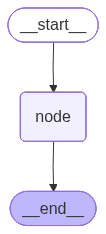

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))